# **Comparison between the kappa.py and wong.py modules**

This notebook contains a comparison between the modules `kappa.py` and `wong.py`. The `kappa.py` module computes the momentum accumulated by a static parton, assuming that its position is fixed and the momentum changes only by virtue of the electric fields of the Glasma. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [2]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 20    
DTS = 8    

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
quark = 'charm'     
mass = 1.275     
tau_form = 1/(2*mass)*hbarc   
pT = 0.5    
ntp = 10**5  
nevents = 10    
representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,       
    'NTP' : ntp,
    }

## Set environment variables

In [4]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import curraun and other packages
import sys
sys.path.append('/n/work00/davrames/curraun/')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_pos, init_charge, init_mom_toy

# Kappa module
import curraun.kappa as kappa

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [5]:

# Simulation routine
def simulate(p, ev): 
    mass = p['MASS']
    pT = p['PT']
    tau_form = p['TFORM']

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    tau = np.linspace(0, tau_sim, maxt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt, 4))

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, tau

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [4]:
quarks = ['beauty', 'charm']
quark_masses = [4.18, 1.27]
# quarks = ['beauty']
# quark_masses = [4.18]
pTs = [0, 2, 5, 10]
# formation_times = [0.02, 0.08]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quarks[iq] 

        mom_broads = []
        for ev in range(nevents):
            mom_broad_ev, tau_wong = simulate(p, ev)
            mom_broads.append(mom_broad_ev)

        mom_broad[tag] = np.mean(mom_broads, axis=0)
        tau[tag] = tau_wong

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'mom_broad_wong_beauty_charm.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Beauty quark
Transverse momentum 0 GeV


Event 20: 100%|██████████| 828/828 [03:17<00:00,  4.19it/s]


Transverse momentum 2 GeV


Event 20: 100%|██████████| 828/828 [03:17<00:00,  4.19it/s]


Transverse momentum 5 GeV


Event 20: 100%|██████████| 828/828 [03:17<00:00,  4.20it/s]


Transverse momentum 10 GeV


Event 20: 100%|██████████| 828/828 [03:18<00:00,  4.18it/s]


Charm quark
Transverse momentum 0 GeV


Event 20: 100%|██████████| 850/850 [03:20<00:00,  4.25it/s]


Transverse momentum 2 GeV


Event 20: 100%|██████████| 850/850 [03:19<00:00,  4.25it/s]


Transverse momentum 5 GeV


Event 20: 100%|██████████| 850/850 [03:20<00:00,  4.24it/s]


Transverse momentum 10 GeV


Event 20: 100%|██████████| 850/850 [03:20<00:00,  4.24it/s]


## Simulation routine for the static quark case

In [6]:
def simulate_kappa(p, ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            if t>=formt:  
                # Compute momentum broadening from Kappa module

                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append((t-formt)*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad_kappa, tau_kappa

## Run over multiple Glasma events and do averages

In [7]:
# quarks = ['infmass', 'beauty', 'charm']
# quark_masses = [10**4, 4.18, 1.27]
quarks = ['infmass']
quark_masses = [10**4, 4.18, 1.27]
# pTs = [0, 2, 5, 10]
# formation_times = [0.02, 0.08]

# N = 1024       
# DTS = 16     
# nevents = 5

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc
    if quarks[iq]=='infmass':
        p['TFORM'] = 0
    # p['TOFMR'] = formation_times[iq]

    tag = quarks[iq]
    p['FOLDER'] = su_group + '_kappa_' + quarks[iq] 

    mom_broads = []
    for ev in range(nevents):
        mom_broad_ev, tau[tag] = simulate_kappa(p, ev)
        mom_broads.append(mom_broad_ev)

    mom_broad[tag] = np.mean(mom_broads, axis=0)

output = {}
output['quarks'], output['masses'] = quarks, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
# filename = 'mom_broad_kappa.pickle'
# filename = 'mom_broad_kappa_beauty_charm.pickle'
filename = 'mom_broad_kappa_infmass_longtime.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Infmass quark


Event 10: 100%|██████████| 8192/8192 [22:15<00:00,  6.13it/s]


In [22]:
import numpy as np
import pickle

# dimenstion of fundamental representation for SU(3)
# all momentum broadening components are divided by DR, see Eq. (82) from Sec. VI. of https://arxiv.org/abs/2303.05599
DR = 3

results = pickle.load(open("mom_broad_kappa_infmass_longtime.pickle", "rb"))

mom_broad, tau = results["mom_broad"], results["tau"]
quark = "infmass"

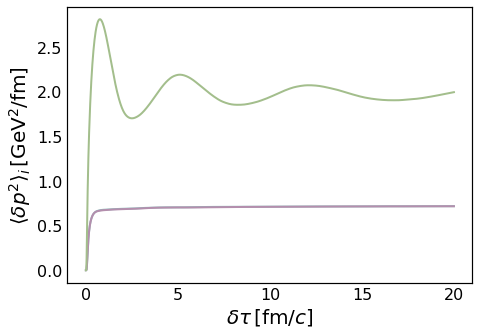

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("../others/nord_theme_light.mpltstyle")
plt.rcParams["figure.figsize"] = (7, 5)
fig, ax = plt.subplots(1, 1)

for i in range(3):
    mom_broad_i = mom_broad[quark][:, i]/DR
    ax.plot(tau[quark], mom_broad_i, linewidth=2)

# plot style 
ax.set_ylabel(r'$\langle \delta p^2\rangle_i\,\mathrm{[GeV^2/fm]}$')
ax.set_xlabel(r'$\delta\tau\,\mathrm{[fm/}c\mathrm{]}$')
# ax.set_xlim(-0.05, 2.05)
# ax.set_ylim(-2.5, 25)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
# plt.savefig('kappa_glasma_' + quark + '.pdf', format='pdf')

## Read data from files using Julia

In [1]:
using Pickle

Qs = 2.0
results = ["wong", "kappa"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "results/mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_wong["quarks"]
pTs = string.(data_wong["pTs"])

4-element Vector{String}:
 "0"
 "2"
 "5"
 "10"

## Plot the results using Makie from Julia

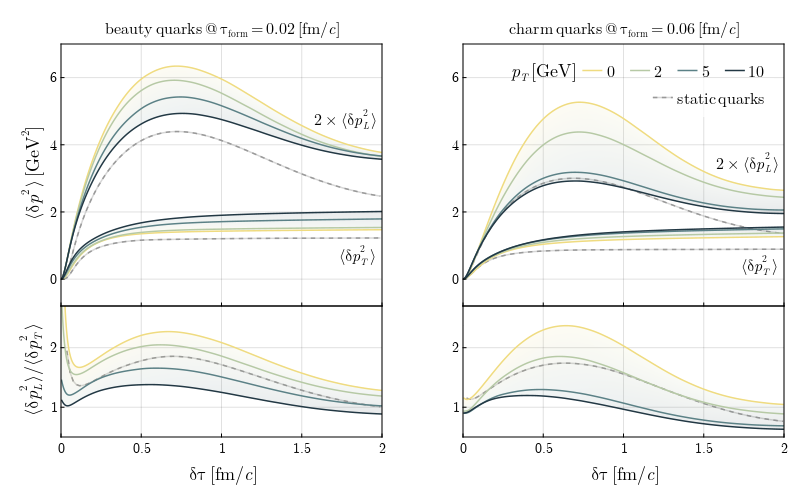

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000bd47fd0, 600.0, 375.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/plots/mom_broad_wong_vs_kappa.pdf>)))


In [2]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]
width_line=1.5

fig = Figure(resolution = (800, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
titles = [[L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/}c\mathrm{]}", 
        L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/}c\mathrm{]}"], ["", ""]]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/}c\mathrm{]}", ylabel=ylabels[i],title=titles[i][j],
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4) for j in 1:2] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = width_line, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = width_line, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = width_line, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = width_line, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = width_line, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = width_line, color=(:grey60, 0.4))

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = width_line, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = width_line, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = width_line, color=colors[ipT]))
    end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false, ticks = false, ticklabels = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], grid = false, ticks = false)
end

ylims!(axes[1][1], -0.8, 7)
ylims!(axes[1][2], -0.8, 7)
axes[1][1].yticks = ([0, 2, 4, 6], string.([0, 2, 4, 6]))
axes[1][2].yticks = ([0, 2, 4, 6], string.([0, 2, 4, 6]))

ylims!(axes[2][1], 0.5, 2.7)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))
axes[2][2].yticks = ([1, 2, 3], string.([1, 2, 3]))


rowsize!(fig.layout, 1, Relative(2/3))
rowsize!(fig.layout, 2, Relative(1/3))

colgap!(fig.layout, 70)
rowgap!(fig.layout, 0)

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[1][2], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=16, 
        titleposition = :left, titlesize=18, 
        # position=:rt,
        position = (1,1.025), 
        orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[1][2], [[kappa, kappa_dash]], legend_kappa, labelsize=16, position = (1,0.88), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.58,4.4), textsize=16)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.74,0.35), textsize=16)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.58,3.1), textsize=16)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.74, 0.05), textsize=16)

display(fig)
save("plots/mom_broad_wong_vs_kappa.png", fig, px_per_unit = 5.0) 
save("plots/mom_broad_wong_vs_kappa.pdf", fig) 

### Ratio between dynamic and static quarks momentum broadenings

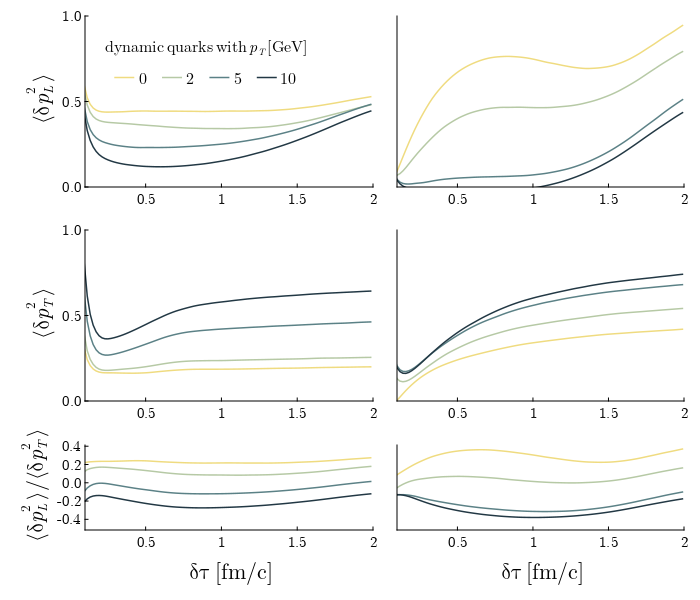

In [3]:
using CairoMakie
using ColorSchemes
using Interpolations

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (700, 600), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle", L"\langle\delta p_T^2\,\rangle", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=15, yticklabelsize=15,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:3]

# dimenstion of fundamental representation for SU(3)
DR = 3

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])
    ratio_kappa = mom_broad_L_kappa./mom_broad_T_kappa

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])


        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]
        interp_wong_L = LinearInterpolation(δτ_wong, mom_broad_L_wong)
        ratio_wong_kappa_L = (interp_wong_L(δτ_kappa).-mom_broad_L_kappa)./mom_broad_L_kappa
        lines!(axes[1][iq], δτ_kappa, ratio_wong_kappa_L, linewidth = 1.5, color=colors[ipT])


        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])
        interp_wong_T = LinearInterpolation(δτ_wong, mom_broad_T_wong)
        ratio_wong_kappa_T = (interp_wong_T(δτ_kappa).-mom_broad_T_kappa)./mom_broad_T_kappa
        lines!(axes[2][iq], δτ_kappa, ratio_wong_kappa_T, linewidth = 1.5, color=colors[ipT])
        ratio = interp_wong_L(δτ_kappa)./interp_wong_T(δτ_kappa)
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[3][iq], δτ_kappa, (ratio.-ratio_kappa)./ratio_kappa, linewidth = 1.5, color=colors[ipT]))
    end
end

for i in 1:3
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0.1, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j], axes[3][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
        hidexdecorations!(axes[2][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], 0, 1)
ylims!(axes[2][1], 0, 1)

rowsize!(fig.layout, 1, Relative(2/5))
rowsize!(fig.layout, 2, Relative(2/5))
rowsize!(fig.layout, 3, Relative(1/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[1][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"\mathrm{dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", labelsize=16, 
        titleposition = :top, titlesize=16, position = :lt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)

### Ratio between beauty and charm momentum broadenings

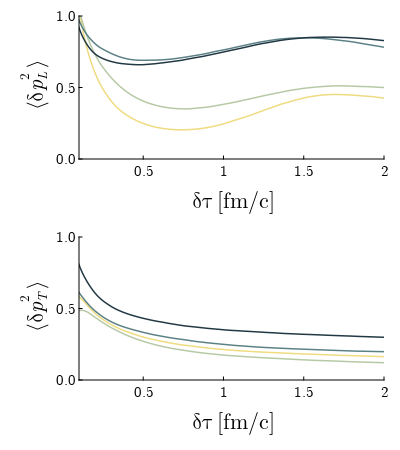

In [4]:
using CairoMakie
using ColorSchemes
using Interpolations

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (400, 450), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle", L"\langle\delta p_T^2\,\rangle"]
axes = [Axis(fig[i, 1], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=15, yticklabelsize=15,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

i = 1
for ipT in 1:length(pTs)
    tag_charm, tag_beauty = quarks[2] * "_pT_" * pTs[ipT], quarks[1] * "_pT_" * pTs[ipT]
    δτ_wong = Float64.(tau_wong[tag_charm])
    mom_broad_L_charm, mom_broad_L_beauty = mom_broad_wong[tag_charm][:, 3], mom_broad_wong[tag_beauty][:, 3]
    lines!(axes[1], δτ_wong, (mom_broad_L_beauty.-mom_broad_L_charm)./mom_broad_L_charm, linewidth = 1.5, color=colors[ipT])

    mom_broad_T_charm, mom_broad_T_beauty = (mom_broad_wong[tag_charm][:, 1]+mom_broad_wong[tag_charm][:, 2]), (mom_broad_wong[tag_beauty][:, 1]+mom_broad_wong[tag_beauty][:, 2])
    lines!(axes[2], δτ_wong, (mom_broad_T_beauty.-mom_broad_T_charm)./mom_broad_T_charm, linewidth = 1.5, color=colors[ipT])
end

for i in 1:2
    xlims!(axes[i], 0.1, 2)
    axes[i].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
end


ylims!(axes[1], 0, 1)
ylims!(axes[2], 0, 1)

display(fig)